## 중고차 플랫폼 개발을 위한 머신 러닝 - SS501
### 	차량 파손 검출

데이터셋 : 쏘카 파손 이미지 데이터셋  
사용 모델 : Efficient-b7  
학습 방법 : Imagenet Pre-trained 된 데이터를 fine-tuning  
손실 함수 : Focal Loss - Data imbalance 문제 해결을 위해 사용 + 에지에 더 집중하도록 Loss 수정  
최적화 방법 : Adam  
스케쥴러 : StepLR 사용 - 10epoch 이후 1/10 으로 LR 조정  
후처리 1 : mIoU를 높이기 위해 CRF와 Threshold 방법 실험 - Threshold 방법이 더 효과적  
후처리 2 : 사용자에게 파손 위치를 쉽게 알려주기 위한 Bounding Box    
    - output 결과에 Labeling을 통해 Bounding box 위치를 찾고 이미지에 Draw  


### Drive mount and package import

In [1]:
#Running from local drive

#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models




In [2]:
# data 경로 설정 
root = os.path.join(os.getcwd())

### Dataset 준비


In [3]:
class SOCAR_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
        
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)[:,:,0]      # 3차원으로 구성된 mask 를 label 로 쓰기 위해 변환

        mask[mask > 0] = 1

        # there is only one class
        mask = torch.as_tensor(mask, dtype=torch.uint8)

        target = {}
        target["masks"] = mask

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

### Transforms
원하는대로 transform 을 수정하거나 추가해봅시다!

RandomVertical Flip 추가, ColorJitter 추가


In [4]:
class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
        return image, target
class RandomVerticalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            if "masks" in target:
                target["masks"] = target["masks"].flip(-2)
        return image, target
class ColorJitter(object):

    def __call__(self, image, target):

        #image = torchvision.transforms.ColorJitter(brightness=(0.2, 3),contrast=(0.2, 3))(image)
        image = torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2)(image)

        return image, target
class ToTensor(object):
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        return image, target

class Resize(object):
    def __init__(self, size):
        self.size = size
    def __call__(self, image, target):
        image = transforms.Resize(self.size)(image)
        if "masks" in target:
            target["masks"] = transforms.Resize(self.size)(target["masks"].unsqueeze(dim=0)).squeeze()
        return image, target

class Normalize(object):
    def __call__(self, image, target):
        image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        return image, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [5]:
def get_transform(train):
    transforms = [ToTensor(), Resize((320,320)), Normalize()]##320/2/2/2/2/2
    if train:
        transforms = [ColorJitter(),ToTensor(), Resize((320,320)), Normalize()]
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(RandomVerticalFlip(0.5))
    return Compose(transforms)

### Model
학습 모델을 정의해봅시다.
기본적인 목표는 pytorch pretrained model 을 불러오고 fine-tuning 을 위해 모델을 수정하는 것을 구현하는 것입니다.
#### (Optional)
직접 모델을 설계하고 구현해서 더 높은 성능을 내는 것도 도전해봅시다!


In [6]:
##########################
#                        #
#         TO DO          #
#                        #
##########################

#여러 모델 적용 및 편한 사용을 위해 Pip로 pytorch segmentation 모델 패키지 설치

#!pip install -U segmentation-models-pytorch 
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
model =model.cuda()




### Dataset split, DataLoader

In [14]:
dent_train = SOCAR_Dataset(os.path.join(root,'accida_segmentation_dataset_v1/scratch/train'), get_transform(train=True))
dent_valid = SOCAR_Dataset(os.path.join(root,'accida_segmentation_dataset_v1/scratch/valid'), get_transform(train=False))
dent_test = SOCAR_Dataset(os.path.join(root,'accida_segmentation_dataset_v1/scratch/test'), get_transform(train=False))


train_loader = DataLoader(dent_train, batch_size=2, shuffle=True, drop_last=True,num_workers=8)
valid_loader = DataLoader(dent_valid, batch_size=2, shuffle=False, drop_last=True,num_workers=8)
test_loader = DataLoader(dent_test, batch_size=1, shuffle=False, drop_last=True,num_workers=8)


### Trainer class 정의

imbalance data 문제 해결을 위한 focal loss 적용

In [27]:
## Trainer class 정의
import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

MAX_ITER = 10
POS_W = 3
POS_XY_STD = 1
Bi_W = 4
Bi_XY_STD = 67
Bi_RGB_STD = 3


def dense_crf(img, output_probs):
    c = output_probs.shape[1]
    h = output_probs.shape[2]
    w = output_probs.shape[3]
    #print(c,h,w)
    img = img.squeeze(0)
    U = utils.unary_from_softmax(output_probs)
    
    U = np.ascontiguousarray(U)

    img = np.ascontiguousarray(img)

    d = dcrf.DenseCRF2D(w, h, c)
    U = U.reshape((c,-1))
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
    d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=img, compat=Bi_W)

    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    return Q


# Data imbalance 해결을 위해 Focalloss 사용.

import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
    
        ce_loss = nn.CrossEntropyLoss(reduction='mean')(inputs, targets)

        pt = torch.exp(-ce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class Semantic_Seg_Trainer(nn.Module):
    def __init__(self, model,opt="adam", num_class=2, lr=0.001, has_scheduler=True, device="cpu", log_dir="./logs", max_epoch=10):
        """
          Args:
            model: 사용할 model
            opt: optimizer
            lr: learning rate
            has_scheduler: learning rate scheduler 사용 여부
            device: 사용할 device (cpu/cuda)
        """
        super().__init__()
        
        self.max_epoch = max_epoch
        self.model = model                            
        self.loss = FocalLoss()            # loss function 정의
        self.num_class = num_class

        self._get_optimizer(opt=opt.lower(), lr=lr)   # optimizer 정의
        self.has_scheduler = has_scheduler            # scheduler 사용여부 
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device                          # 사용할 device
        
        self.log_dir = log_dir
        if not os.path.exists(log_dir): os.makedirs(log_dir)

    def _get_optimizer(self, opt, lr=0.001):
        """
          Args:
            opt: optimizer
            lr: learning rate
        """
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"optimizer {opt} is not supproted")

    def _get_scheduler(self):
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=10, gamma=0.1, verbose=True)

    def train(self, train_loader, valid_loader, max_epochs=10, disp_step=1, visualize=False):
        """
          네트워크를 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
            valid_loader: validation에 사용할 dataloader
            max_epochs: 학습을 진행할 총 epoch 수
            disp_epochs: 학습 log를 display 할 epoch 주기
            visualize: 학습 진행 과정에서 결과 이미지를 visualize 
        """
        print("===== Train Start =====")
        start_time = time.time()   
        history = {"train_loss": [], "valid_loss": [], "train_miou": [], "valid_miou": []}
        best_loss=1
        for e in range(max_epochs):
            print(f"Start Train Epoch {e}")
            train_loss, train_miou = self._train_epoch(train_loader)
            print(f"Start Valid Epoch {e}")
            valid_loss, valid_miou = self._valid_epoch(valid_loader)
            
            
            history["train_loss"].append(train_loss)      # 현재 epoch에서 성능을 history dict에 저장
            history["valid_loss"].append(valid_loss)      #
            
            history["train_miou"].append(train_miou)      # 
            history["valid_miou"].append(valid_miou)      #

            if self.has_scheduler:         # scheduler 사용할 경우 step size 조절
                self.scheduler.step()
            disp_epoch = max_epochs
            if e % disp_epoch == 0:        # disp_epoch 마다 결과값 출력 
                print(f"Epoch: {e}, train loss: {train_loss:>6f}, valid loss: {valid_loss:>6f}, train miou: {train_miou:>6f}, valid miou: {valid_miou:>6f}, time: {time.time()-start_time:>3f}")
                
                start_time = time.time()   

            self.plot_history(history, save_name=f"{self.log_dir}/log_epoch_{e}.png")       # 그래프 출력
            #################################################################################################
            #                                                                                               #
            # TODO : 한 epoch 의 학습이 끝날때 마다 model 을 save 하는 코드를 작성해봅시다.                 #
            #        graph 저장 코드를 참고하여 저장되는 model 의 이름에 몇 epoch 인지 나타나게 해봅시다.   # 
            #                                                                                               #
            #################################################################################################
            model_data = "./epoch_"+str(e) +".pth"
            torch.save(model, model_data)
            if best_loss > valid_loss:
                best_loss = valid_loss
                print("Best model chaged.")
                torch.save(model, "./best_model.pth")
                
    def _train_epoch(self, train_loader, disp_step=10):
        """
          model를 training set 한 epoch 만큼 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
          Returns:
            training set 한 epoch의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        
        miou = 0
        ious = np.zeros([2])
        
        self.model.train()                 # self.model을 train 모드로 전환 --> nn.Module의 내장함수
        cnt = 0
        epoch_start_time = time.time()
        start_time = time.time()
        for (x, y) in train_loader:        # x: data, y:label
            cnt += 1

            x = x.to(self.device)
            label = y['masks'].to(self.device).type(torch.long)
                        
            outs = self.model(x)              # model이 예측한 output
            sigmoid= nn.Sigmoid()
            outs = sigmoid(outs)
            out ={}
            out['out'] =outs
            
            loss = self.loss(out['out'], label)       
            
            self.optimizer.zero_grad()       # backwardpass를 통한 network parameter 업데이트
            loss.backward()                  # 
            self.optimizer.step()            # 
            
            epoch_loss += loss.to("cpu").item()    
            
            out_background = torch.argmin(out['out'].to("cpu"), dim=1).to(self.device)           # meanIoU 계산을 위한 데이터 변형
            out_target = torch.argmax(out['out'].to("cpu"), dim=1).to(self.device)               #
            
            ious[0] += self.batch_segmentation_iou(out_background, torch.logical_not(label).type(torch.long)) # ious[0]:background IoU
            ious[1] += self.batch_segmentation_iou(out_target, label)                                         # ious[1]:파손 IoU
            
            if cnt % disp_step == 0:
                iou_back = ious[0]/(cnt*x.shape[0])
                iou_scratch = ious[1]/(cnt*x.shape[0])
                miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
                
                print(f"Iter: {cnt}/{len(train_loader)}, train epcoh loss: {epoch_loss/(cnt):>6f}, miou: {miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-start_time:>3f}")
                start_time = time.time()   

        epoch_loss /= len(train_loader)  
        
        
        iou_back = ious[0]/(cnt*x.shape[0])
        iou_scratch = ious[1]/(cnt*x.shape[0])
        epoch_miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
        print(f"Train loss: {epoch_loss:>6f}, miou: {epoch_miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-epoch_start_time:>3f}")

        return epoch_loss, epoch_miou
  
    def _valid_epoch(self, valid_loader, disp_step=10):
        """
          현재 model의 성능을 validation set에서 측정하는 함수
          Args:
            valid_loader: 학습에 사용할 valid dataloader
          Returns:
            validation set 의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        
        miou = 0
        ious = np.zeros([2])
                      
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        cnt = 0
        epoch_start_time = time.time()
        start_time = time.time()
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in valid_loader:
                cnt += 1
                x = x.to(self.device)
                label = y['masks'].to(self.device).type(torch.long)

                outs = self.model(x)              # model이 예측한 output
                sigmoid= nn.Sigmoid()
                outs = sigmoid(outs)
                out ={}
                out['out'] =outs
                loss = self.loss(out['out'], label)
                      
                epoch_loss += loss.to("cpu").item()
                img = x
                x = x.data.cpu().numpy().astype(np.uint8).transpose(0, 2, 3, 1)            
                out['out'] = out['out'].data.cpu().numpy()                   
                out['out'] = dense_crf(x,out['out'])
                out['out'] = torch.from_numpy(out['out']).cuda()                      
                
                out_background = torch.argmin(out['out'].to("cpu"), dim=0).to(self.device)
                out_target = torch.argmax(out['out'].to("cpu"), dim=0).to(self.device)
                #out_background = torch.argmin(out['out'].to("cpu"), dim=1).to(self.device)
                #out_target = torch.argmax(out['out'].to("cpu"), dim=1).to(self.device)

                ious[0] += self.batch_segmentation_iou(out_background, torch.logical_not(label).type(torch.long))
                ious[1] += self.batch_segmentation_iou(out_target, label)
                    

                
                
                if cnt % disp_step == 0:
                    iou_back = ious[0]/(cnt*x.shape[0])
                    iou_scratch = ious[1]/(cnt*x.shape[0])
                    miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
                    print(f"Iter: {cnt}/{len(valid_loader)}, valid epcoh loss: {epoch_loss/(cnt):>6f}, miou: {miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-start_time:>3f}")
                    start_time = time.time()   

        epoch_loss /= len(valid_loader)
        
        iou_back = ious[0]/(cnt*x.shape[0])
        iou_scratch = ious[1]/(cnt*x.shape[0])
        epoch_miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
        print(f"Valid loss: {epoch_loss:>6f}, miou: {epoch_miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-epoch_start_time:>3f}")

        return epoch_loss, epoch_miou

    def plot_history(self, history, save_name=None):
        """
          history에 저장된 model의 성능을 graph로 plot
          Args:
            history: dictionary with keys {"train_loss","valid_loss",  }
                     각 item 들은 epoch 단위의 성능 history의 list
        """
        fig = plt.figure(figsize=(16, 8))
        
        
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(history["train_loss"], color="red", label="train loss")
        ax.plot(history["valid_loss"], color="blue", label="valid loss")
        ax.title.set_text("Loss")
        ax.legend()
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(history["train_miou"], color="red", label="train miou")
        ax.plot(history["valid_miou"], color="blue", label="valid miou")
        ax.title.set_text("miou")
        ax.legend()

        plt.show()
                      
        if not save_name == None:     # graph 저장
            plt.savefig(save_name)
                      
        

    def test(self, test_loader):
        """
          현재 model의 성능을 test set에서 측정하는 함수
          Args:
            test_loader: 학습에 사용할 test dataloader
          Returns:
            test set 의 평균 loss, 평균 accuracy
        """
        print("===== Test Start =====")
        start_time = time.time()
        epoch_loss = 0
        
        miou = 0
        ious = np.zeros([2])
                      
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        cnt = 0
        epoch_start_time = time.time()
        start_time = time.time()
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in test_loader:
                cnt += 1
                x = x.to(self.device)
                label = y['masks'].to(self.device).type(torch.long)

                outs = self.model(x)              # model이 예측한 output
                sigmoid= nn.Sigmoid()
                outs = sigmoid(outs)
                out ={}
                out['out'] =outs
               
                loss = self.loss(out['out'], label)

                epoch_loss += loss.to("cpu").item()
                
                #crf post processing
                #img = x
                #x = x.data.cpu().numpy().astype(np.uint8).transpose(0, 2, 3, 1)            
                #out['out'] = out['out'].data.cpu().numpy()                   
                #out['out'] = dense_crf(x,out['out'])
                #out['out'] = torch.from_numpy(out['out']).cuda()
                
                #threshold post processing
                out['out']  = torch.as_tensor((out['out']  - 0.5) > 0, dtype=torch.int32)
                
                
                out_background = torch.argmin(out['out'].to("cpu"), dim=1).to(self.device)
                out_target = torch.argmax(out['out'].to("cpu"), dim=1).to(self.device)

                ious[0] += self.batch_segmentation_iou(out_background, torch.logical_not(label).type(torch.long))
                ious[1] += self.batch_segmentation_iou(out_target, label)
                
                if cnt % 10 == 0:
                    iou_back = ious[0]/(cnt*x.shape[0])
                    iou_scratch = ious[1]/(cnt*x.shape[0])
                    miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
                    print(f"Iter: {cnt}/{len(valid_loader)}, test epcoh loss: {epoch_loss/(cnt):>6f}, miou: {miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-start_time:>3f}")
                    start_time = time.time()  

        epoch_loss /= len(test_loader)
        
        
        iou_back = ious[0]/(cnt*x.shape[0])
        iou_scratch = ious[1]/(cnt*x.shape[0])
        epoch_miou = (ious[0]/(cnt*x.shape[0]) + ious[1]/(cnt*x.shape[0])) / 2.
        
        print(f"Test loss: {epoch_loss:>6f}, miou: {epoch_miou:>6f}, iou_back : {iou_back:>6f}, iou_scratch : {iou_scratch:>6f}, time: {time.time()-epoch_start_time:>3f}")

    
    def batch_segmentation_iou(self, outputs, labels):
        """
            outputs, labels : (batch, h, w)
        """
        
        SMOOTH = 1e-6

        intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
        union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0

        iou = (intersection+SMOOTH)/(union+SMOOTH)# TODO
        
        #################################################################################################
        #                                                                                               #
        # TODO : 위 코드를 보고 IoU 를 계산하는 코드를 만들어봅시다.                                    #
        # hint : 나누기에서 0으로 나누면 error 가 발생하기 때문에 이를 피하기 위해 분자와 분모에        #
        #        아주 작은 수인 SMOOTH 를 더해줍시다                                                    #
        #        ex) x / y   --->   (x + SMOOTH) / (y + SMOOTH)                                         #
        #                                                                                               #
        #################################################################################################
        
        
        return torch.sum(iou).to("cpu").numpy()

### Fine-tuning
device 를 gpu 로 설정하고 trainer를 정의해봅시다.
정의된 trainer 와 train, valid 데이터로 모델을 학습을 시켜봅시다

In [9]:
#################################################################################################
#                                                                                               #
# TODO : trainer 를 정의해봅시다.                                                               #
#                                                                                               #
#################################################################################################
trainer = Semantic_Seg_Trainer(model,device="cuda",lr=0.0001,has_scheduler=True)

Adjusting learning rate of group 0 to 1.0000e-04.


===== Train Start =====
Start Train Epoch 0
Iter: 10/1066, train epcoh loss: 0.133637, miou: 0.414641, iou_back : 0.796458, iou_scratch : 0.032823, time: 5.252356
Iter: 20/1066, train epcoh loss: 0.127901, miou: 0.430807, iou_back : 0.830881, iou_scratch : 0.030734, time: 4.598126
Iter: 30/1066, train epcoh loss: 0.123428, miou: 0.438072, iou_back : 0.850756, iou_scratch : 0.025388, time: 4.613597
Iter: 40/1066, train epcoh loss: 0.119877, miou: 0.445175, iou_back : 0.864408, iou_scratch : 0.025942, time: 4.609709
Iter: 50/1066, train epcoh loss: 0.115931, miou: 0.451915, iou_back : 0.880126, iou_scratch : 0.023705, time: 4.595918
Iter: 60/1066, train epcoh loss: 0.112824, miou: 0.456104, iou_back : 0.889998, iou_scratch : 0.022209, time: 4.587181
Iter: 70/1066, train epcoh loss: 0.109850, miou: 0.459270, iou_back : 0.898068, iou_scratch : 0.020473, time: 4.593518
Iter: 80/1066, train epcoh loss: 0.106942, miou: 0.462392, iou_back : 0.906319, iou_scratch : 0.018466, time: 4.593203
Iter

Iter: 690/1066, train epcoh loss: 0.053824, miou: 0.597320, iou_back : 0.961042, iou_scratch : 0.233598, time: 4.596769
Iter: 700/1066, train epcoh loss: 0.053534, miou: 0.597103, iou_back : 0.961245, iou_scratch : 0.232962, time: 4.600688
Iter: 710/1066, train epcoh loss: 0.053297, miou: 0.598195, iou_back : 0.961251, iou_scratch : 0.235139, time: 4.612036
Iter: 720/1066, train epcoh loss: 0.053016, miou: 0.599044, iou_back : 0.961487, iou_scratch : 0.236601, time: 4.594651
Iter: 730/1066, train epcoh loss: 0.052798, miou: 0.598979, iou_back : 0.961484, iou_scratch : 0.236473, time: 4.613369
Iter: 740/1066, train epcoh loss: 0.052540, miou: 0.599156, iou_back : 0.961646, iou_scratch : 0.236666, time: 4.628300
Iter: 750/1066, train epcoh loss: 0.052278, miou: 0.600116, iou_back : 0.961858, iou_scratch : 0.238374, time: 4.589798
Iter: 760/1066, train epcoh loss: 0.052005, miou: 0.601362, iou_back : 0.962137, iou_scratch : 0.240587, time: 4.593249
Iter: 770/1066, train epcoh loss: 0.0517

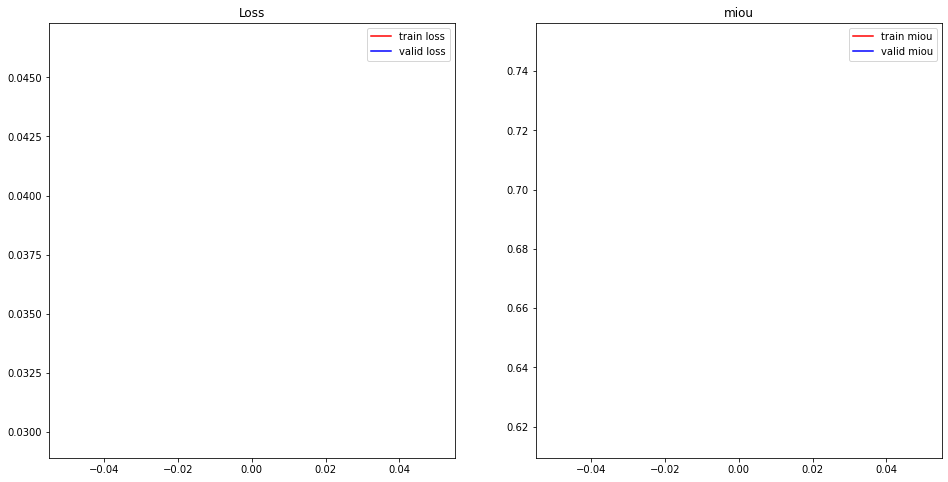

Best model chaged.
Start Train Epoch 1
Iter: 10/1066, train epcoh loss: 0.034717, miou: 0.605727, iou_back : 0.959051, iou_scratch : 0.252403, time: 5.028736
Iter: 20/1066, train epcoh loss: 0.033395, miou: 0.622265, iou_back : 0.964641, iou_scratch : 0.279888, time: 4.629349
Iter: 30/1066, train epcoh loss: 0.033184, miou: 0.629234, iou_back : 0.965040, iou_scratch : 0.293429, time: 4.608202
Iter: 40/1066, train epcoh loss: 0.032554, miou: 0.634238, iou_back : 0.967779, iou_scratch : 0.300696, time: 4.600208
Iter: 50/1066, train epcoh loss: 0.033199, miou: 0.632673, iou_back : 0.965150, iou_scratch : 0.300195, time: 4.651962
Iter: 60/1066, train epcoh loss: 0.032937, miou: 0.632010, iou_back : 0.966064, iou_scratch : 0.297957, time: 4.648056
Iter: 70/1066, train epcoh loss: 0.032464, miou: 0.639251, iou_back : 0.968056, iou_scratch : 0.310446, time: 4.671911
Iter: 80/1066, train epcoh loss: 0.032193, miou: 0.635680, iou_back : 0.969160, iou_scratch : 0.302200, time: 4.664654
Iter: 90/

Iter: 700/1066, train epcoh loss: 0.030397, miou: 0.663808, iou_back : 0.974433, iou_scratch : 0.353183, time: 4.606009
Iter: 710/1066, train epcoh loss: 0.030396, miou: 0.663906, iou_back : 0.974415, iou_scratch : 0.353398, time: 4.635559
Iter: 720/1066, train epcoh loss: 0.030417, miou: 0.663921, iou_back : 0.974285, iou_scratch : 0.353557, time: 4.625476
Iter: 730/1066, train epcoh loss: 0.030397, miou: 0.663580, iou_back : 0.974316, iou_scratch : 0.352844, time: 4.603656
Iter: 740/1066, train epcoh loss: 0.030384, miou: 0.663859, iou_back : 0.974312, iou_scratch : 0.353406, time: 4.671371
Iter: 750/1066, train epcoh loss: 0.030370, miou: 0.663791, iou_back : 0.974359, iou_scratch : 0.353223, time: 4.609570
Iter: 760/1066, train epcoh loss: 0.030353, miou: 0.664579, iou_back : 0.974403, iou_scratch : 0.354754, time: 4.604942
Iter: 770/1066, train epcoh loss: 0.030321, miou: 0.665031, iou_back : 0.974511, iou_scratch : 0.355552, time: 4.619239
Iter: 780/1066, train epcoh loss: 0.0302

<Figure size 432x288 with 0 Axes>

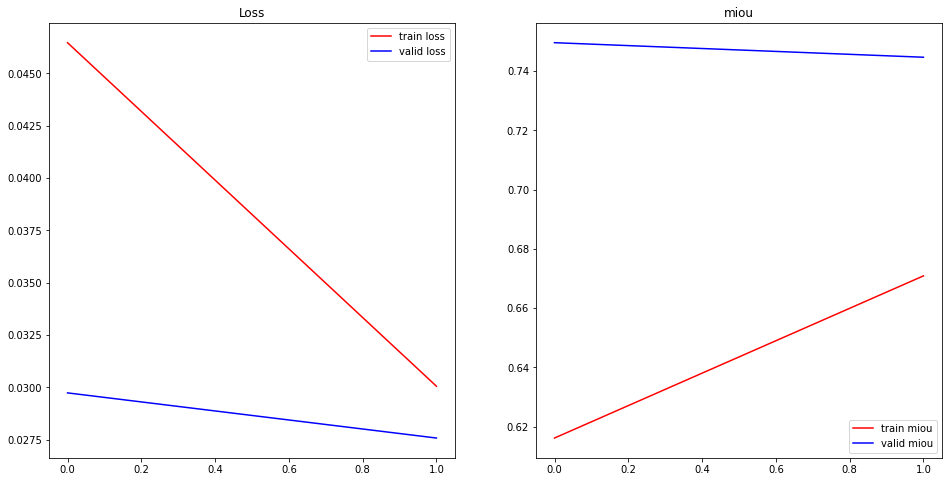

Best model chaged.
Start Train Epoch 2
Iter: 10/1066, train epcoh loss: 0.030742, miou: 0.689696, iou_back : 0.966282, iou_scratch : 0.413109, time: 5.010084
Iter: 20/1066, train epcoh loss: 0.030006, miou: 0.680287, iou_back : 0.970463, iou_scratch : 0.390111, time: 4.600249
Iter: 30/1066, train epcoh loss: 0.029146, miou: 0.680986, iou_back : 0.974719, iou_scratch : 0.387254, time: 4.608780
Iter: 40/1066, train epcoh loss: 0.028603, miou: 0.682175, iou_back : 0.977377, iou_scratch : 0.386972, time: 4.593218
Iter: 50/1066, train epcoh loss: 0.028099, miou: 0.697573, iou_back : 0.979900, iou_scratch : 0.415246, time: 4.625074
Iter: 60/1066, train epcoh loss: 0.028099, miou: 0.697681, iou_back : 0.980109, iou_scratch : 0.415253, time: 4.597115
Iter: 70/1066, train epcoh loss: 0.028325, miou: 0.702507, iou_back : 0.979064, iou_scratch : 0.425950, time: 4.619366
Iter: 80/1066, train epcoh loss: 0.028247, miou: 0.695568, iou_back : 0.979372, iou_scratch : 0.411764, time: 4.641027
Iter: 90/

Iter: 700/1066, train epcoh loss: 0.028822, miou: 0.700279, iou_back : 0.976385, iou_scratch : 0.424172, time: 4.603006
Iter: 710/1066, train epcoh loss: 0.028837, miou: 0.699694, iou_back : 0.976320, iou_scratch : 0.423069, time: 4.637689
Iter: 720/1066, train epcoh loss: 0.028806, miou: 0.699188, iou_back : 0.976459, iou_scratch : 0.421917, time: 4.602602
Iter: 730/1066, train epcoh loss: 0.028811, miou: 0.698443, iou_back : 0.976429, iou_scratch : 0.420458, time: 4.638836
Iter: 740/1066, train epcoh loss: 0.028790, miou: 0.697678, iou_back : 0.976505, iou_scratch : 0.418850, time: 4.600340
Iter: 750/1066, train epcoh loss: 0.028756, miou: 0.698768, iou_back : 0.976654, iou_scratch : 0.420881, time: 4.603950
Iter: 760/1066, train epcoh loss: 0.028740, miou: 0.699243, iou_back : 0.976724, iou_scratch : 0.421762, time: 4.629338
Iter: 770/1066, train epcoh loss: 0.028731, miou: 0.699226, iou_back : 0.976751, iou_scratch : 0.421701, time: 4.610963
Iter: 780/1066, train epcoh loss: 0.0287

<Figure size 432x288 with 0 Axes>

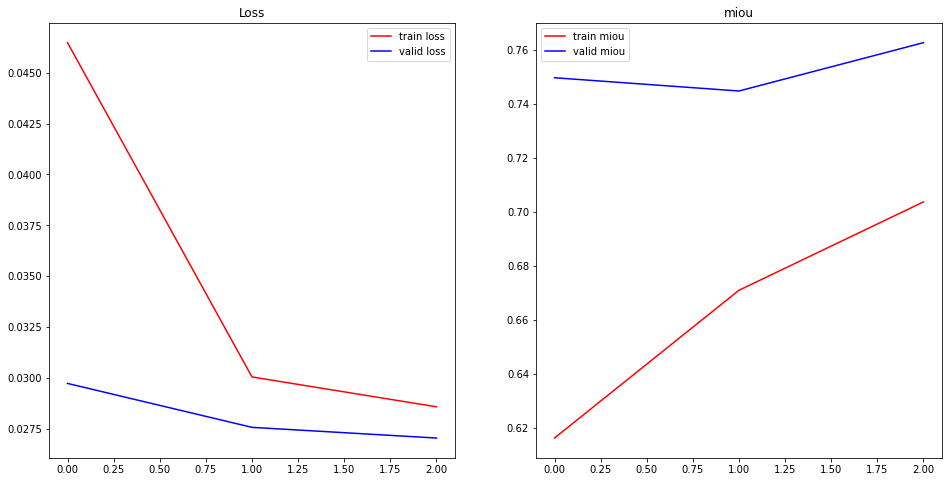

Best model chaged.
Start Train Epoch 3
Iter: 10/1066, train epcoh loss: 0.027817, miou: 0.786400, iou_back : 0.979520, iou_scratch : 0.593281, time: 4.996301
Iter: 20/1066, train epcoh loss: 0.028247, miou: 0.730356, iou_back : 0.977672, iou_scratch : 0.483040, time: 4.586786
Iter: 30/1066, train epcoh loss: 0.027776, miou: 0.714426, iou_back : 0.979384, iou_scratch : 0.449468, time: 4.606861
Iter: 40/1066, train epcoh loss: 0.028252, miou: 0.703515, iou_back : 0.977359, iou_scratch : 0.429671, time: 4.609040
Iter: 50/1066, train epcoh loss: 0.028430, miou: 0.700197, iou_back : 0.976497, iou_scratch : 0.423897, time: 4.622962
Iter: 60/1066, train epcoh loss: 0.028421, miou: 0.705494, iou_back : 0.976587, iou_scratch : 0.434401, time: 4.599552
Iter: 70/1066, train epcoh loss: 0.028263, miou: 0.705055, iou_back : 0.977310, iou_scratch : 0.432801, time: 4.600371
Iter: 80/1066, train epcoh loss: 0.028125, miou: 0.714799, iou_back : 0.978056, iou_scratch : 0.451542, time: 4.598292
Iter: 90/

Iter: 700/1066, train epcoh loss: 0.027782, miou: 0.714298, iou_back : 0.979373, iou_scratch : 0.449222, time: 4.608228
Iter: 710/1066, train epcoh loss: 0.027779, miou: 0.714140, iou_back : 0.979376, iou_scratch : 0.448905, time: 4.609252
Iter: 720/1066, train epcoh loss: 0.027768, miou: 0.715138, iou_back : 0.979429, iou_scratch : 0.450848, time: 4.612664
Iter: 730/1066, train epcoh loss: 0.027753, miou: 0.714681, iou_back : 0.979505, iou_scratch : 0.449858, time: 4.608172
Iter: 740/1066, train epcoh loss: 0.027771, miou: 0.714104, iou_back : 0.979427, iou_scratch : 0.448781, time: 4.598149
Iter: 750/1066, train epcoh loss: 0.027757, miou: 0.714622, iou_back : 0.979480, iou_scratch : 0.449765, time: 4.600119
Iter: 760/1066, train epcoh loss: 0.027776, miou: 0.714660, iou_back : 0.979403, iou_scratch : 0.449916, time: 4.600483
Iter: 770/1066, train epcoh loss: 0.027759, miou: 0.715197, iou_back : 0.979489, iou_scratch : 0.450905, time: 4.624632
Iter: 780/1066, train epcoh loss: 0.0277

<Figure size 432x288 with 0 Axes>

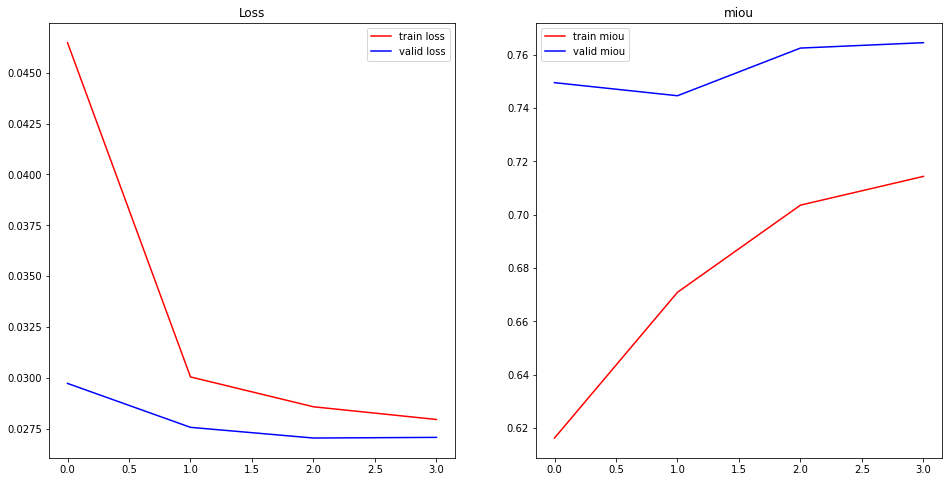

Start Train Epoch 4
Iter: 10/1066, train epcoh loss: 0.028284, miou: 0.764123, iou_back : 0.976777, iou_scratch : 0.551468, time: 5.019238
Iter: 20/1066, train epcoh loss: 0.028247, miou: 0.756496, iou_back : 0.976675, iou_scratch : 0.536317, time: 4.606327
Iter: 30/1066, train epcoh loss: 0.027685, miou: 0.750584, iou_back : 0.979124, iou_scratch : 0.522044, time: 4.615077
Iter: 40/1066, train epcoh loss: 0.027392, miou: 0.746666, iou_back : 0.980631, iou_scratch : 0.512701, time: 4.614137
Iter: 50/1066, train epcoh loss: 0.027760, miou: 0.740509, iou_back : 0.979201, iou_scratch : 0.501817, time: 4.616912
Iter: 60/1066, train epcoh loss: 0.027590, miou: 0.740420, iou_back : 0.979875, iou_scratch : 0.500964, time: 4.602020
Iter: 70/1066, train epcoh loss: 0.027421, miou: 0.738053, iou_back : 0.980699, iou_scratch : 0.495408, time: 4.603624
Iter: 80/1066, train epcoh loss: 0.027402, miou: 0.740553, iou_back : 0.980852, iou_scratch : 0.500254, time: 4.599472
Iter: 90/1066, train epcoh l

Iter: 700/1066, train epcoh loss: 0.027413, miou: 0.731345, iou_back : 0.980284, iou_scratch : 0.482407, time: 4.621172
Iter: 710/1066, train epcoh loss: 0.027427, miou: 0.733336, iou_back : 0.980229, iou_scratch : 0.486444, time: 4.600937
Iter: 720/1066, train epcoh loss: 0.027430, miou: 0.733574, iou_back : 0.980203, iou_scratch : 0.486946, time: 4.654319
Iter: 730/1066, train epcoh loss: 0.027441, miou: 0.733215, iou_back : 0.980123, iou_scratch : 0.486308, time: 4.611042
Iter: 740/1066, train epcoh loss: 0.027453, miou: 0.733560, iou_back : 0.980078, iou_scratch : 0.487042, time: 4.610864
Iter: 750/1066, train epcoh loss: 0.027449, miou: 0.733382, iou_back : 0.980100, iou_scratch : 0.486663, time: 4.609079
Iter: 760/1066, train epcoh loss: 0.027462, miou: 0.732971, iou_back : 0.980054, iou_scratch : 0.485888, time: 4.635782
Iter: 770/1066, train epcoh loss: 0.027454, miou: 0.733332, iou_back : 0.980091, iou_scratch : 0.486573, time: 4.606262
Iter: 780/1066, train epcoh loss: 0.0274

<Figure size 432x288 with 0 Axes>

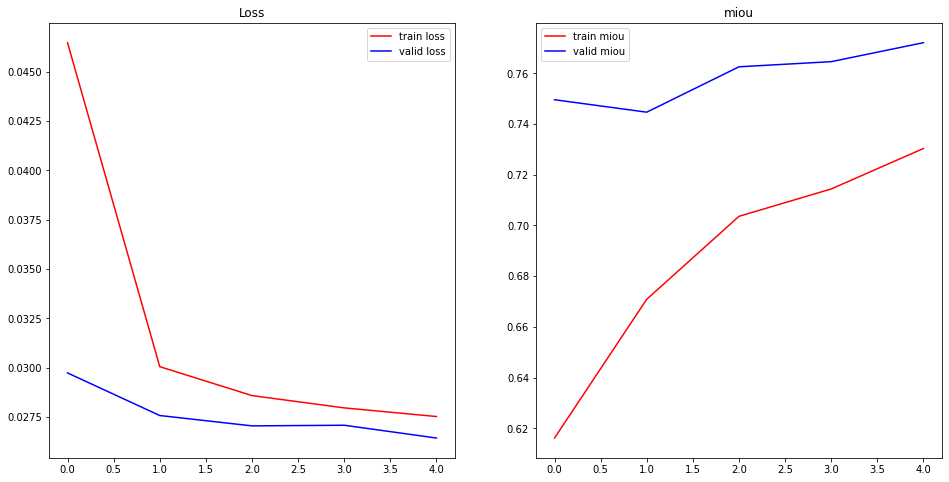

Best model chaged.
Start Train Epoch 5
Iter: 10/1066, train epcoh loss: 0.027991, miou: 0.688744, iou_back : 0.975778, iou_scratch : 0.401711, time: 5.019568
Iter: 20/1066, train epcoh loss: 0.027597, miou: 0.703918, iou_back : 0.978689, iou_scratch : 0.429147, time: 4.608628
Iter: 30/1066, train epcoh loss: 0.027531, miou: 0.715078, iou_back : 0.978974, iou_scratch : 0.451183, time: 4.612099
Iter: 40/1066, train epcoh loss: 0.026934, miou: 0.717066, iou_back : 0.982021, iou_scratch : 0.452112, time: 4.624115
Iter: 50/1066, train epcoh loss: 0.026945, miou: 0.705892, iou_back : 0.982091, iou_scratch : 0.429693, time: 4.613390
Iter: 60/1066, train epcoh loss: 0.026759, miou: 0.721132, iou_back : 0.983060, iou_scratch : 0.459203, time: 4.612090
Iter: 70/1066, train epcoh loss: 0.026794, miou: 0.721549, iou_back : 0.982940, iou_scratch : 0.460157, time: 4.629484
Iter: 80/1066, train epcoh loss: 0.026925, miou: 0.726119, iou_back : 0.982363, iou_scratch : 0.469875, time: 4.599502
Iter: 90/

Iter: 700/1066, train epcoh loss: 0.027258, miou: 0.739550, iou_back : 0.980847, iou_scratch : 0.498253, time: 5.960252
Iter: 710/1066, train epcoh loss: 0.027244, miou: 0.740390, iou_back : 0.980915, iou_scratch : 0.499866, time: 6.011097
Iter: 720/1066, train epcoh loss: 0.027235, miou: 0.739667, iou_back : 0.980948, iou_scratch : 0.498386, time: 5.962969
Iter: 730/1066, train epcoh loss: 0.027235, miou: 0.740396, iou_back : 0.980941, iou_scratch : 0.499850, time: 5.885333
Iter: 740/1066, train epcoh loss: 0.027214, miou: 0.741095, iou_back : 0.981043, iou_scratch : 0.501147, time: 6.386773
Iter: 750/1066, train epcoh loss: 0.027196, miou: 0.741221, iou_back : 0.981128, iou_scratch : 0.501313, time: 5.900927
Iter: 760/1066, train epcoh loss: 0.027202, miou: 0.741150, iou_back : 0.981093, iou_scratch : 0.501207, time: 5.869617
Iter: 770/1066, train epcoh loss: 0.027206, miou: 0.741492, iou_back : 0.981068, iou_scratch : 0.501916, time: 5.921336
Iter: 780/1066, train epcoh loss: 0.0272

<Figure size 432x288 with 0 Axes>

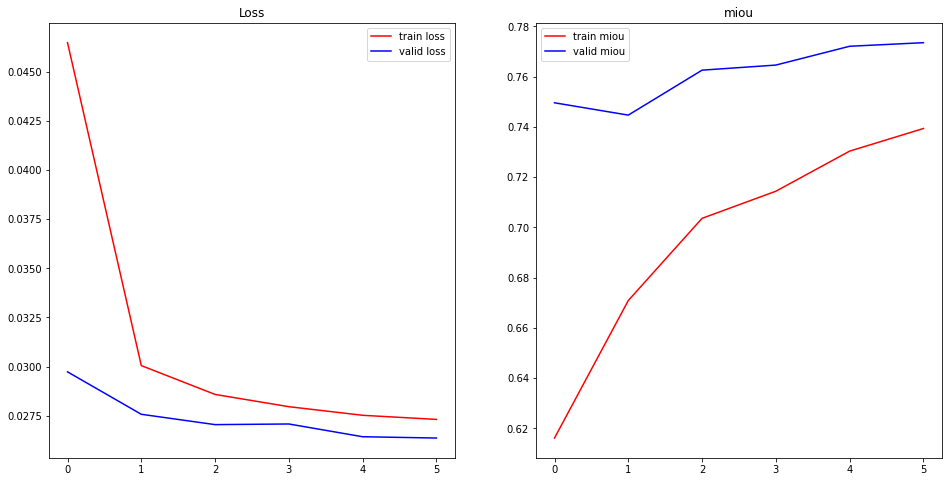

Best model chaged.
Start Train Epoch 6
Iter: 10/1066, train epcoh loss: 0.027567, miou: 0.769956, iou_back : 0.980775, iou_scratch : 0.559137, time: 6.633379
Iter: 20/1066, train epcoh loss: 0.026821, miou: 0.762533, iou_back : 0.983539, iou_scratch : 0.541527, time: 5.901977
Iter: 30/1066, train epcoh loss: 0.026640, miou: 0.783716, iou_back : 0.984166, iou_scratch : 0.583266, time: 6.055925
Iter: 40/1066, train epcoh loss: 0.026943, miou: 0.777119, iou_back : 0.982704, iou_scratch : 0.571534, time: 6.073160
Iter: 50/1066, train epcoh loss: 0.027229, miou: 0.775706, iou_back : 0.981113, iou_scratch : 0.570298, time: 6.001488
Iter: 60/1066, train epcoh loss: 0.027357, miou: 0.774127, iou_back : 0.980265, iou_scratch : 0.567990, time: 6.095592
Iter: 70/1066, train epcoh loss: 0.027155, miou: 0.766995, iou_back : 0.981211, iou_scratch : 0.552779, time: 5.794883
Iter: 80/1066, train epcoh loss: 0.027206, miou: 0.761757, iou_back : 0.980923, iou_scratch : 0.542591, time: 6.081421
Iter: 90/

Iter: 700/1066, train epcoh loss: 0.027144, miou: 0.746996, iou_back : 0.981235, iou_scratch : 0.512757, time: 5.961089
Iter: 710/1066, train epcoh loss: 0.027130, miou: 0.747416, iou_back : 0.981297, iou_scratch : 0.513536, time: 6.059110
Iter: 720/1066, train epcoh loss: 0.027129, miou: 0.747449, iou_back : 0.981290, iou_scratch : 0.513609, time: 5.900297
Iter: 730/1066, train epcoh loss: 0.027157, miou: 0.746557, iou_back : 0.981183, iou_scratch : 0.511932, time: 6.156361
Iter: 740/1066, train epcoh loss: 0.027156, miou: 0.747067, iou_back : 0.981178, iou_scratch : 0.512956, time: 5.910900
Iter: 750/1066, train epcoh loss: 0.027163, miou: 0.747139, iou_back : 0.981118, iou_scratch : 0.513160, time: 5.762379
Iter: 760/1066, train epcoh loss: 0.027172, miou: 0.747678, iou_back : 0.981070, iou_scratch : 0.514285, time: 6.386834
Iter: 770/1066, train epcoh loss: 0.027165, miou: 0.748332, iou_back : 0.981096, iou_scratch : 0.515568, time: 6.045809
Iter: 780/1066, train epcoh loss: 0.0271

<Figure size 432x288 with 0 Axes>

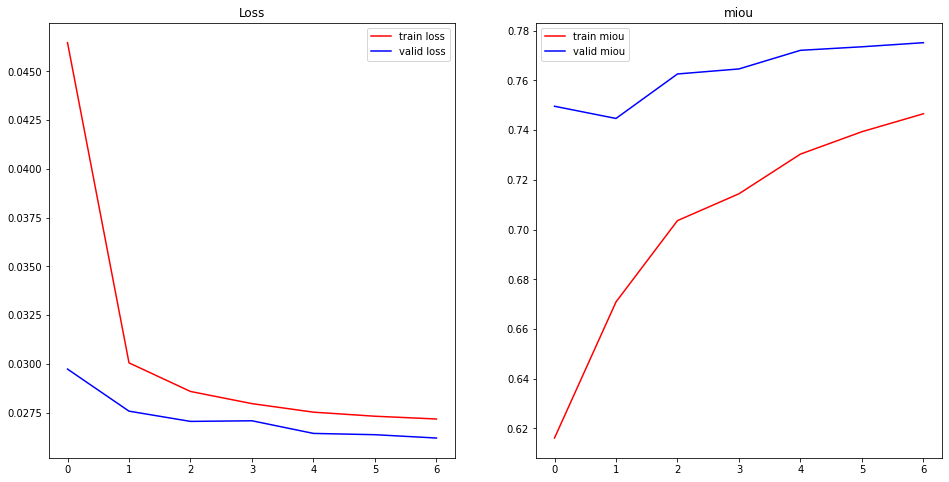

Best model chaged.
Start Train Epoch 7
Iter: 10/1066, train epcoh loss: 0.026147, miou: 0.758505, iou_back : 0.985486, iou_scratch : 0.531523, time: 6.634059
Iter: 20/1066, train epcoh loss: 0.026262, miou: 0.770347, iou_back : 0.985196, iou_scratch : 0.555498, time: 6.090872
Iter: 30/1066, train epcoh loss: 0.027233, miou: 0.746818, iou_back : 0.980689, iou_scratch : 0.512947, time: 5.968080
Iter: 40/1066, train epcoh loss: 0.027658, miou: 0.726474, iou_back : 0.978521, iou_scratch : 0.474428, time: 5.914204
Iter: 50/1066, train epcoh loss: 0.027427, miou: 0.724933, iou_back : 0.979644, iou_scratch : 0.470222, time: 5.803725
Iter: 60/1066, train epcoh loss: 0.027527, miou: 0.730765, iou_back : 0.979031, iou_scratch : 0.482498, time: 6.054329
Iter: 70/1066, train epcoh loss: 0.027260, miou: 0.738243, iou_back : 0.980308, iou_scratch : 0.496178, time: 6.105733
Iter: 80/1066, train epcoh loss: 0.027089, miou: 0.745244, iou_back : 0.981166, iou_scratch : 0.509322, time: 5.946576
Iter: 90/

Iter: 700/1066, train epcoh loss: 0.027002, miou: 0.745008, iou_back : 0.981545, iou_scratch : 0.508471, time: 5.890484
Iter: 710/1066, train epcoh loss: 0.027011, miou: 0.744326, iou_back : 0.981489, iou_scratch : 0.507163, time: 6.038556
Iter: 720/1066, train epcoh loss: 0.026994, miou: 0.744260, iou_back : 0.981571, iou_scratch : 0.506948, time: 6.123370
Iter: 730/1066, train epcoh loss: 0.026982, miou: 0.744505, iou_back : 0.981632, iou_scratch : 0.507378, time: 5.997125
Iter: 740/1066, train epcoh loss: 0.026975, miou: 0.744437, iou_back : 0.981668, iou_scratch : 0.507207, time: 6.071552
Iter: 750/1066, train epcoh loss: 0.026957, miou: 0.744265, iou_back : 0.981755, iou_scratch : 0.506774, time: 6.003557
Iter: 760/1066, train epcoh loss: 0.027036, miou: 0.744604, iou_back : 0.981440, iou_scratch : 0.507768, time: 5.981031
Iter: 770/1066, train epcoh loss: 0.027009, miou: 0.745286, iou_back : 0.981574, iou_scratch : 0.508999, time: 5.798405
Iter: 780/1066, train epcoh loss: 0.0270

<Figure size 432x288 with 0 Axes>

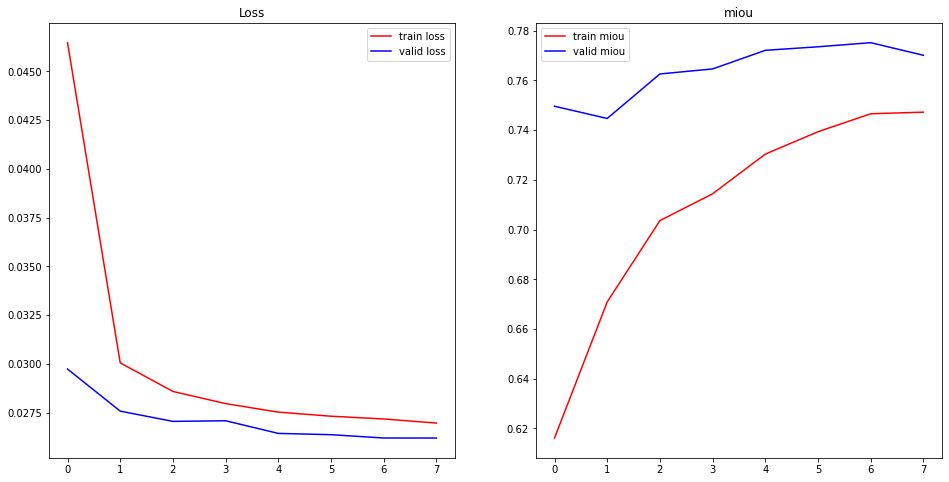

Best model chaged.
Start Train Epoch 8
Iter: 10/1066, train epcoh loss: 0.029064, miou: 0.713464, iou_back : 0.972483, iou_scratch : 0.454445, time: 6.580936
Iter: 20/1066, train epcoh loss: 0.027336, miou: 0.769272, iou_back : 0.980193, iou_scratch : 0.558350, time: 5.689809
Iter: 30/1066, train epcoh loss: 0.026625, miou: 0.768207, iou_back : 0.983606, iou_scratch : 0.552807, time: 6.105332
Iter: 40/1066, train epcoh loss: 0.026795, miou: 0.753068, iou_back : 0.982607, iou_scratch : 0.523530, time: 5.856661
Iter: 50/1066, train epcoh loss: 0.026850, miou: 0.756290, iou_back : 0.982300, iou_scratch : 0.530280, time: 6.069490
Iter: 60/1066, train epcoh loss: 0.026770, miou: 0.758036, iou_back : 0.982571, iou_scratch : 0.533501, time: 6.225621
Iter: 70/1066, train epcoh loss: 0.026765, miou: 0.750040, iou_back : 0.982619, iou_scratch : 0.517460, time: 5.986746
Iter: 80/1066, train epcoh loss: 0.026900, miou: 0.743909, iou_back : 0.981893, iou_scratch : 0.505924, time: 6.519502
Iter: 90/

Iter: 700/1066, train epcoh loss: 0.026783, miou: 0.750572, iou_back : 0.982469, iou_scratch : 0.518675, time: 5.865523
Iter: 710/1066, train epcoh loss: 0.026831, miou: 0.750717, iou_back : 0.982247, iou_scratch : 0.519187, time: 6.033532
Iter: 720/1066, train epcoh loss: 0.026838, miou: 0.751147, iou_back : 0.982209, iou_scratch : 0.520084, time: 6.128902
Iter: 730/1066, train epcoh loss: 0.026830, miou: 0.751414, iou_back : 0.982254, iou_scratch : 0.520574, time: 5.961605
Iter: 740/1066, train epcoh loss: 0.026844, miou: 0.751574, iou_back : 0.982172, iou_scratch : 0.520977, time: 6.056719
Iter: 750/1066, train epcoh loss: 0.026854, miou: 0.751229, iou_back : 0.982147, iou_scratch : 0.520311, time: 6.092703
Iter: 760/1066, train epcoh loss: 0.026851, miou: 0.750766, iou_back : 0.982162, iou_scratch : 0.519369, time: 5.989322
Iter: 770/1066, train epcoh loss: 0.026881, miou: 0.749705, iou_back : 0.982023, iou_scratch : 0.517387, time: 5.896536
Iter: 780/1066, train epcoh loss: 0.0268

<Figure size 432x288 with 0 Axes>

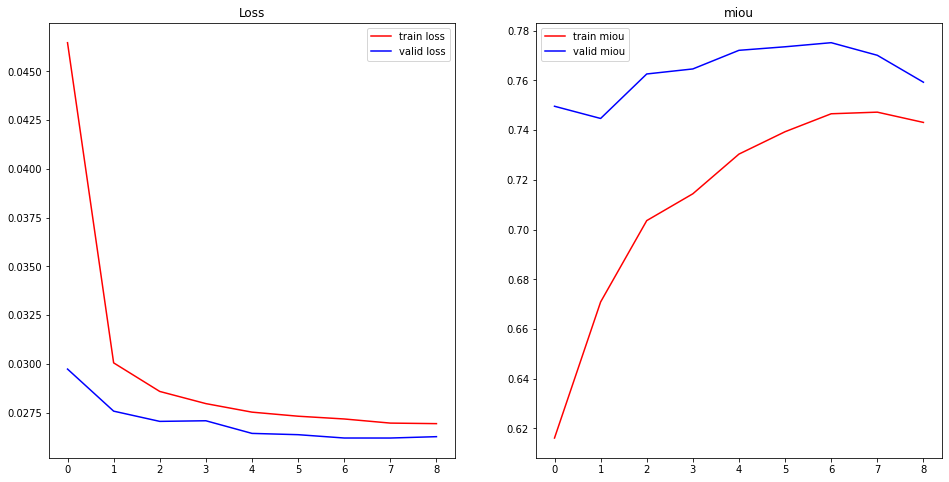

Start Train Epoch 9
Iter: 10/1066, train epcoh loss: 0.029110, miou: 0.707719, iou_back : 0.971763, iou_scratch : 0.443675, time: 6.940239
Iter: 20/1066, train epcoh loss: 0.027816, miou: 0.709766, iou_back : 0.978320, iou_scratch : 0.441212, time: 6.733068
Iter: 30/1066, train epcoh loss: 0.027321, miou: 0.727437, iou_back : 0.980246, iou_scratch : 0.474628, time: 6.563738
Iter: 40/1066, train epcoh loss: 0.027533, miou: 0.735592, iou_back : 0.978935, iou_scratch : 0.492249, time: 6.104557
Iter: 50/1066, train epcoh loss: 0.027579, miou: 0.731221, iou_back : 0.978766, iou_scratch : 0.483675, time: 6.209929
Iter: 60/1066, train epcoh loss: 0.027571, miou: 0.730728, iou_back : 0.978765, iou_scratch : 0.482690, time: 6.195111
Iter: 70/1066, train epcoh loss: 0.027542, miou: 0.730556, iou_back : 0.978878, iou_scratch : 0.482234, time: 5.525708
Iter: 80/1066, train epcoh loss: 0.027486, miou: 0.736738, iou_back : 0.979268, iou_scratch : 0.494209, time: 5.815075
Iter: 90/1066, train epcoh l

Iter: 700/1066, train epcoh loss: 0.026876, miou: 0.748552, iou_back : 0.981982, iou_scratch : 0.515122, time: 5.632357
Iter: 710/1066, train epcoh loss: 0.026908, miou: 0.748241, iou_back : 0.981834, iou_scratch : 0.514648, time: 6.146558
Iter: 720/1066, train epcoh loss: 0.026908, miou: 0.747728, iou_back : 0.981827, iou_scratch : 0.513629, time: 5.737984
Iter: 730/1066, train epcoh loss: 0.026903, miou: 0.748245, iou_back : 0.981844, iou_scratch : 0.514646, time: 5.747293
Iter: 740/1066, train epcoh loss: 0.026913, miou: 0.749243, iou_back : 0.981833, iou_scratch : 0.516653, time: 5.924659
Iter: 750/1066, train epcoh loss: 0.026920, miou: 0.749426, iou_back : 0.981806, iou_scratch : 0.517046, time: 6.325404
Iter: 760/1066, train epcoh loss: 0.026906, miou: 0.749389, iou_back : 0.981871, iou_scratch : 0.516908, time: 6.215506
Iter: 770/1066, train epcoh loss: 0.026900, miou: 0.749783, iou_back : 0.981900, iou_scratch : 0.517667, time: 6.141554
Iter: 780/1066, train epcoh loss: 0.0268

<Figure size 432x288 with 0 Axes>

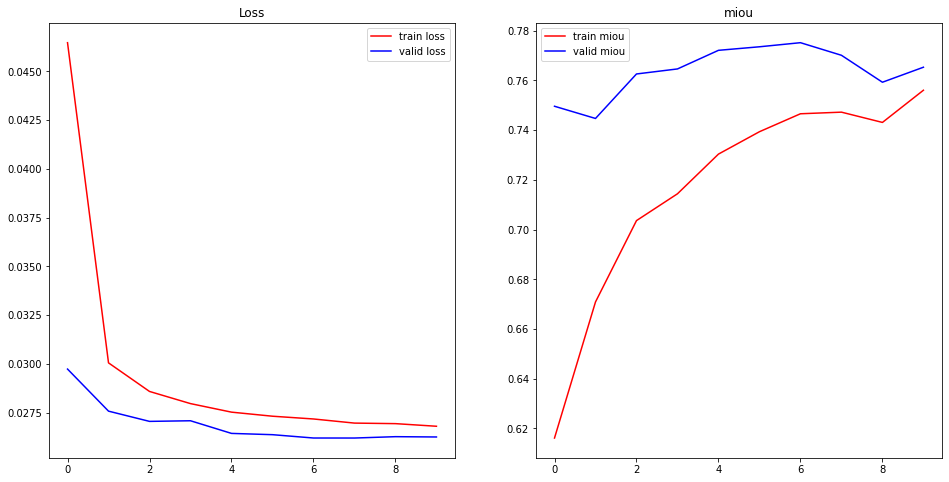

Start Train Epoch 10
Iter: 10/1066, train epcoh loss: 0.027924, miou: 0.712640, iou_back : 0.977199, iou_scratch : 0.448082, time: 5.753675
Iter: 20/1066, train epcoh loss: 0.026651, miou: 0.738306, iou_back : 0.983404, iou_scratch : 0.493209, time: 5.397591
Iter: 30/1066, train epcoh loss: 0.026671, miou: 0.728053, iou_back : 0.983268, iou_scratch : 0.472839, time: 5.198304
Iter: 40/1066, train epcoh loss: 0.027294, miou: 0.730810, iou_back : 0.980212, iou_scratch : 0.481407, time: 5.392896
Iter: 50/1066, train epcoh loss: 0.027245, miou: 0.742568, iou_back : 0.980350, iou_scratch : 0.504787, time: 5.280434
Iter: 60/1066, train epcoh loss: 0.027396, miou: 0.736265, iou_back : 0.979644, iou_scratch : 0.492886, time: 5.464402
Iter: 70/1066, train epcoh loss: 0.027374, miou: 0.742758, iou_back : 0.979761, iou_scratch : 0.505756, time: 5.303499
Iter: 80/1066, train epcoh loss: 0.027437, miou: 0.756593, iou_back : 0.979664, iou_scratch : 0.533522, time: 5.345783
Iter: 90/1066, train epcoh 

Iter: 700/1066, train epcoh loss: 0.026564, miou: 0.775002, iou_back : 0.983536, iou_scratch : 0.566469, time: 4.602605
Iter: 710/1066, train epcoh loss: 0.026570, miou: 0.775501, iou_back : 0.983494, iou_scratch : 0.567509, time: 4.617291
Iter: 720/1066, train epcoh loss: 0.026580, miou: 0.775613, iou_back : 0.983436, iou_scratch : 0.567790, time: 4.629557
Iter: 730/1066, train epcoh loss: 0.026569, miou: 0.774659, iou_back : 0.983495, iou_scratch : 0.565823, time: 4.604307
Iter: 740/1066, train epcoh loss: 0.026556, miou: 0.774576, iou_back : 0.983560, iou_scratch : 0.565592, time: 4.611264
Iter: 750/1066, train epcoh loss: 0.026553, miou: 0.774746, iou_back : 0.983571, iou_scratch : 0.565921, time: 4.588933
Iter: 760/1066, train epcoh loss: 0.026559, miou: 0.774929, iou_back : 0.983538, iou_scratch : 0.566320, time: 4.611173
Iter: 770/1066, train epcoh loss: 0.026552, miou: 0.775016, iou_back : 0.983582, iou_scratch : 0.566450, time: 4.630641
Iter: 780/1066, train epcoh loss: 0.0265

<Figure size 432x288 with 0 Axes>

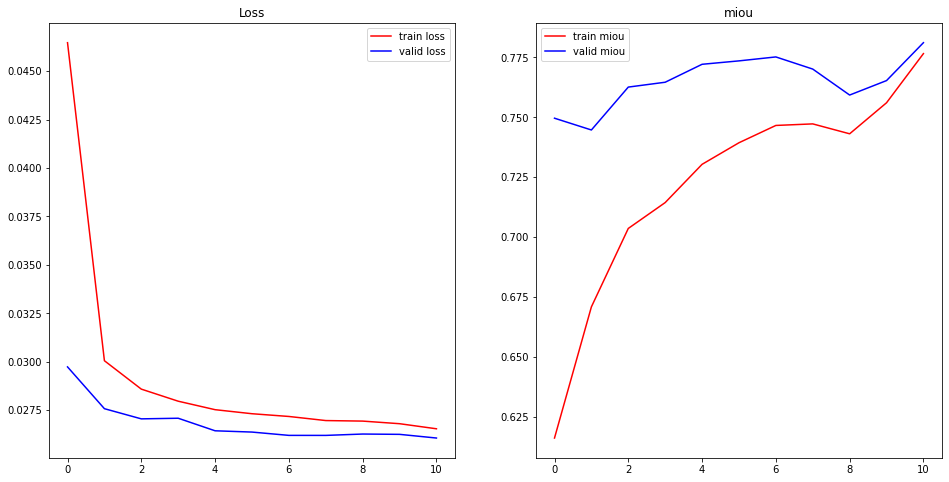

Best model chaged.
Start Train Epoch 11
Iter: 10/1066, train epcoh loss: 0.028036, miou: 0.780379, iou_back : 0.976173, iou_scratch : 0.584584, time: 5.036032
Iter: 20/1066, train epcoh loss: 0.027323, miou: 0.796423, iou_back : 0.979865, iou_scratch : 0.612980, time: 4.628525
Iter: 30/1066, train epcoh loss: 0.027257, miou: 0.794090, iou_back : 0.980064, iou_scratch : 0.608116, time: 4.599448
Iter: 40/1066, train epcoh loss: 0.026928, miou: 0.780988, iou_back : 0.981547, iou_scratch : 0.580429, time: 4.636990
Iter: 50/1066, train epcoh loss: 0.027314, miou: 0.784402, iou_back : 0.979414, iou_scratch : 0.589390, time: 4.614358
Iter: 60/1066, train epcoh loss: 0.027226, miou: 0.777618, iou_back : 0.979886, iou_scratch : 0.575350, time: 4.601114
Iter: 70/1066, train epcoh loss: 0.027091, miou: 0.776000, iou_back : 0.980597, iou_scratch : 0.571404, time: 4.601140
Iter: 80/1066, train epcoh loss: 0.026936, miou: 0.785108, iou_back : 0.981377, iou_scratch : 0.588839, time: 4.601001
Iter: 90

Iter: 700/1066, train epcoh loss: 0.026520, miou: 0.776165, iou_back : 0.983667, iou_scratch : 0.568664, time: 4.645256
Iter: 710/1066, train epcoh loss: 0.026572, miou: 0.776076, iou_back : 0.983447, iou_scratch : 0.568704, time: 4.602449
Iter: 720/1066, train epcoh loss: 0.026559, miou: 0.776381, iou_back : 0.983516, iou_scratch : 0.569247, time: 4.703252
Iter: 730/1066, train epcoh loss: 0.026586, miou: 0.775480, iou_back : 0.983375, iou_scratch : 0.567585, time: 4.645262
Iter: 740/1066, train epcoh loss: 0.026575, miou: 0.776032, iou_back : 0.983430, iou_scratch : 0.568635, time: 4.602114
Iter: 750/1066, train epcoh loss: 0.026571, miou: 0.775540, iou_back : 0.983455, iou_scratch : 0.567626, time: 4.612728
Iter: 760/1066, train epcoh loss: 0.026554, miou: 0.775550, iou_back : 0.983537, iou_scratch : 0.567562, time: 4.607803
Iter: 770/1066, train epcoh loss: 0.026539, miou: 0.776009, iou_back : 0.983613, iou_scratch : 0.568406, time: 4.599988
Iter: 780/1066, train epcoh loss: 0.0265

<Figure size 432x288 with 0 Axes>

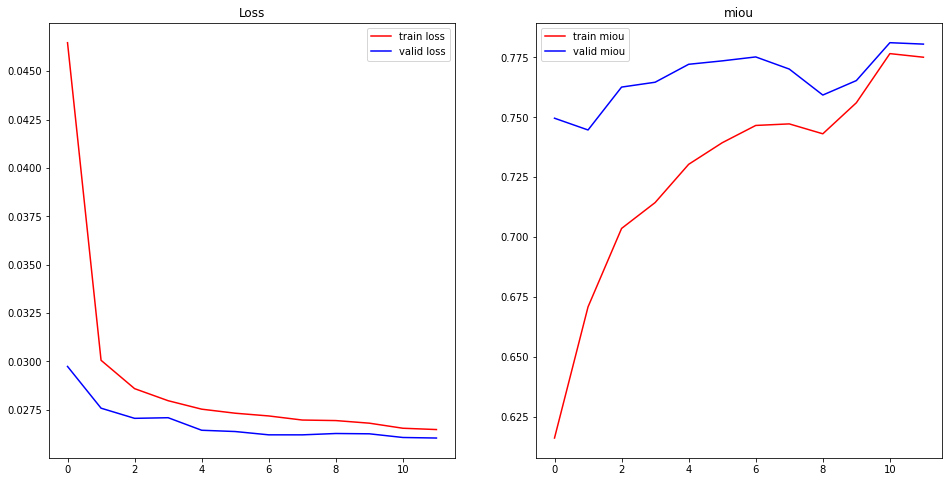

Best model chaged.
Start Train Epoch 12
Iter: 10/1066, train epcoh loss: 0.025893, miou: 0.855704, iou_back : 0.986639, iou_scratch : 0.724770, time: 4.994884
Iter: 20/1066, train epcoh loss: 0.025090, miou: 0.855466, iou_back : 0.990822, iou_scratch : 0.720110, time: 4.640856
Iter: 30/1066, train epcoh loss: 0.025416, miou: 0.839809, iou_back : 0.989057, iou_scratch : 0.690562, time: 4.602036
Iter: 40/1066, train epcoh loss: 0.025542, miou: 0.809880, iou_back : 0.988556, iou_scratch : 0.631204, time: 4.659701
Iter: 50/1066, train epcoh loss: 0.025753, miou: 0.807856, iou_back : 0.987529, iou_scratch : 0.628183, time: 4.606732
Iter: 60/1066, train epcoh loss: 0.025924, miou: 0.809262, iou_back : 0.986572, iou_scratch : 0.631951, time: 4.622384
Iter: 70/1066, train epcoh loss: 0.026260, miou: 0.806690, iou_back : 0.985046, iou_scratch : 0.628334, time: 4.632285
Iter: 80/1066, train epcoh loss: 0.026233, miou: 0.802056, iou_back : 0.985135, iou_scratch : 0.618978, time: 4.599447
Iter: 90

Iter: 700/1066, train epcoh loss: 0.026362, miou: 0.782081, iou_back : 0.984437, iou_scratch : 0.579725, time: 4.669225
Iter: 710/1066, train epcoh loss: 0.026366, miou: 0.781528, iou_back : 0.984422, iou_scratch : 0.578634, time: 4.682930
Iter: 720/1066, train epcoh loss: 0.026380, miou: 0.781421, iou_back : 0.984361, iou_scratch : 0.578481, time: 4.620944
Iter: 730/1066, train epcoh loss: 0.026378, miou: 0.780477, iou_back : 0.984373, iou_scratch : 0.576581, time: 4.647448
Iter: 740/1066, train epcoh loss: 0.026372, miou: 0.780554, iou_back : 0.984400, iou_scratch : 0.576708, time: 4.602265
Iter: 750/1066, train epcoh loss: 0.026384, miou: 0.780029, iou_back : 0.984338, iou_scratch : 0.575719, time: 4.597183
Iter: 760/1066, train epcoh loss: 0.026388, miou: 0.780023, iou_back : 0.984318, iou_scratch : 0.575728, time: 4.617397
Iter: 770/1066, train epcoh loss: 0.026387, miou: 0.779863, iou_back : 0.984318, iou_scratch : 0.575408, time: 4.612022
Iter: 780/1066, train epcoh loss: 0.0263

<Figure size 432x288 with 0 Axes>

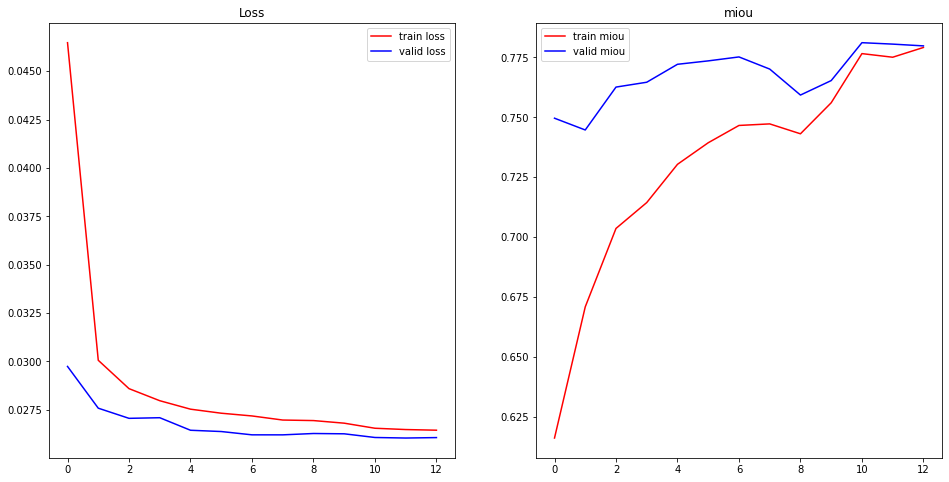

Start Train Epoch 13
Iter: 10/1066, train epcoh loss: 0.025177, miou: 0.758438, iou_back : 0.989985, iou_scratch : 0.526892, time: 4.934586
Iter: 20/1066, train epcoh loss: 0.025321, miou: 0.782896, iou_back : 0.989452, iou_scratch : 0.576340, time: 4.598243
Iter: 30/1066, train epcoh loss: 0.025896, miou: 0.796137, iou_back : 0.986754, iou_scratch : 0.605520, time: 4.604191
Iter: 40/1066, train epcoh loss: 0.025818, miou: 0.804610, iou_back : 0.987305, iou_scratch : 0.621915, time: 4.606687
Iter: 50/1066, train epcoh loss: 0.025938, miou: 0.786830, iou_back : 0.986679, iou_scratch : 0.586981, time: 4.604781
Iter: 60/1066, train epcoh loss: 0.025888, miou: 0.782549, iou_back : 0.986937, iou_scratch : 0.578162, time: 4.625014
Iter: 70/1066, train epcoh loss: 0.025826, miou: 0.781524, iou_back : 0.987245, iou_scratch : 0.575804, time: 4.627821
Iter: 80/1066, train epcoh loss: 0.025848, miou: 0.779170, iou_back : 0.987087, iou_scratch : 0.571253, time: 4.645809
Iter: 90/1066, train epcoh 

Iter: 700/1066, train epcoh loss: 0.026287, miou: 0.781698, iou_back : 0.984737, iou_scratch : 0.578660, time: 4.613197
Iter: 710/1066, train epcoh loss: 0.026287, miou: 0.782324, iou_back : 0.984729, iou_scratch : 0.579920, time: 4.619184
Iter: 720/1066, train epcoh loss: 0.026305, miou: 0.782078, iou_back : 0.984682, iou_scratch : 0.579474, time: 4.608654
Iter: 730/1066, train epcoh loss: 0.026319, miou: 0.781936, iou_back : 0.984599, iou_scratch : 0.579273, time: 4.620809
Iter: 740/1066, train epcoh loss: 0.026319, miou: 0.780982, iou_back : 0.984593, iou_scratch : 0.577371, time: 4.633189
Iter: 750/1066, train epcoh loss: 0.026313, miou: 0.781157, iou_back : 0.984625, iou_scratch : 0.577690, time: 4.599850
Iter: 760/1066, train epcoh loss: 0.026298, miou: 0.780844, iou_back : 0.984704, iou_scratch : 0.576985, time: 4.603897
Iter: 770/1066, train epcoh loss: 0.026289, miou: 0.781140, iou_back : 0.984751, iou_scratch : 0.577529, time: 4.664780
Iter: 780/1066, train epcoh loss: 0.0262

<Figure size 432x288 with 0 Axes>

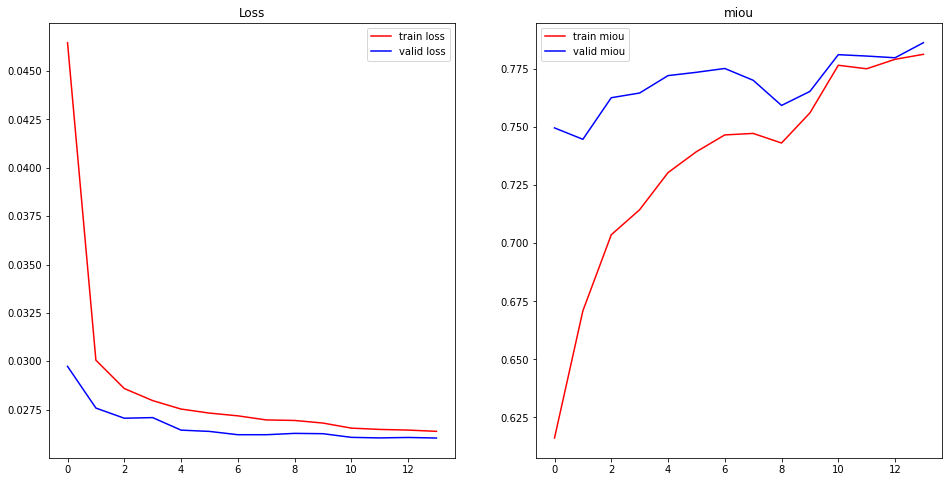

Best model chaged.
Start Train Epoch 14
Iter: 10/1066, train epcoh loss: 0.027110, miou: 0.791363, iou_back : 0.979752, iou_scratch : 0.602974, time: 5.565335
Iter: 20/1066, train epcoh loss: 0.026774, miou: 0.770920, iou_back : 0.981693, iou_scratch : 0.560147, time: 5.059521
Iter: 30/1066, train epcoh loss: 0.026567, miou: 0.773849, iou_back : 0.982998, iou_scratch : 0.564700, time: 5.157467
Iter: 40/1066, train epcoh loss: 0.026298, miou: 0.785935, iou_back : 0.984332, iou_scratch : 0.587538, time: 5.088142
Iter: 50/1066, train epcoh loss: 0.026282, miou: 0.778553, iou_back : 0.984682, iou_scratch : 0.572424, time: 5.242998
Iter: 60/1066, train epcoh loss: 0.026788, miou: 0.777911, iou_back : 0.982812, iou_scratch : 0.573010, time: 5.150101
Iter: 70/1066, train epcoh loss: 0.026744, miou: 0.782179, iou_back : 0.982997, iou_scratch : 0.581362, time: 5.414226
Iter: 80/1066, train epcoh loss: 0.026884, miou: 0.786165, iou_back : 0.982190, iou_scratch : 0.590139, time: 4.997336
Iter: 90

Iter: 700/1066, train epcoh loss: 0.026350, miou: 0.783490, iou_back : 0.984409, iou_scratch : 0.582571, time: 6.218454
Iter: 710/1066, train epcoh loss: 0.026358, miou: 0.783811, iou_back : 0.984367, iou_scratch : 0.583254, time: 5.996476
Iter: 720/1066, train epcoh loss: 0.026361, miou: 0.784184, iou_back : 0.984355, iou_scratch : 0.584013, time: 6.289736
Iter: 730/1066, train epcoh loss: 0.026353, miou: 0.784048, iou_back : 0.984390, iou_scratch : 0.583705, time: 6.081387
Iter: 740/1066, train epcoh loss: 0.026330, miou: 0.784043, iou_back : 0.984511, iou_scratch : 0.583574, time: 6.007054
Iter: 750/1066, train epcoh loss: 0.026330, miou: 0.783665, iou_back : 0.984513, iou_scratch : 0.582816, time: 6.254962
Iter: 760/1066, train epcoh loss: 0.026332, miou: 0.783575, iou_back : 0.984513, iou_scratch : 0.582637, time: 6.095478
Iter: 770/1066, train epcoh loss: 0.026319, miou: 0.783454, iou_back : 0.984579, iou_scratch : 0.582330, time: 6.044798
Iter: 780/1066, train epcoh loss: 0.0263

<Figure size 432x288 with 0 Axes>

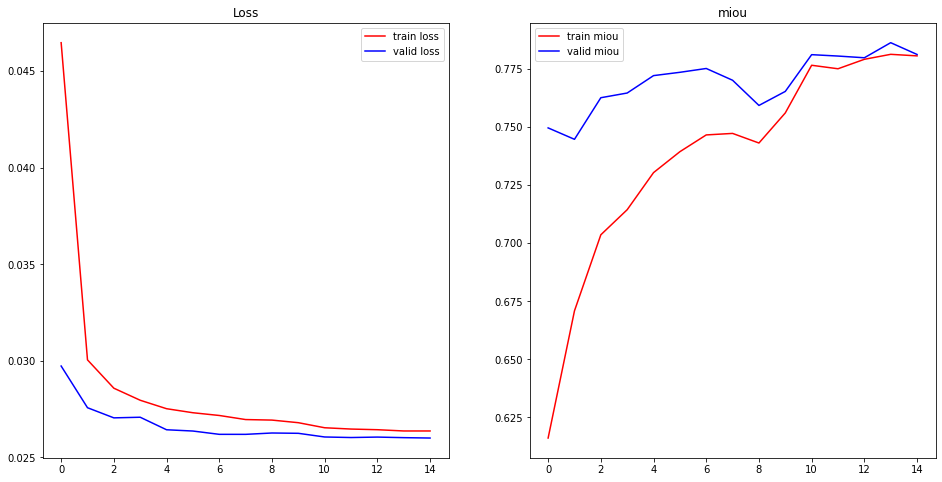

Best model chaged.
Training time : 8506.396911


<Figure size 432x288 with 0 Axes>

In [11]:
start_time = time.time()
trainer.train(train_loader, valid_loader, max_epochs=15, disp_step=1)
print(f"Training time : {time.time()-start_time:>3f}")

### Fine-tuning 결과 테스트
학습된 모델 parameter 를 load 하여 test 성능을 확인해보고 test set 에서 좋은 예시를 찾아서 visualize 해봅시다.

In [28]:
#################################################################################################
#                                                                                               #
# TODO : save 한 model parameter 를 load 하여 test set 에서 성능을 확인해봅시다.                #
#                                                                                               #
#################################################################################################

seg_model = torch.load("./better_result.pth")
seg_trainer = Semantic_Seg_Trainer(seg_model,device="cuda")
seg_trainer.test(test_loader)


Adjusting learning rate of group 0 to 1.0000e-03.
===== Test Start =====
Iter: 10/133, test epcoh loss: 0.022720, miou: 0.899827, iou_back : 0.999654, iou_scratch : 0.800000, time: 0.755714
Iter: 20/133, test epcoh loss: 0.022695, miou: 0.924903, iou_back : 0.999807, iou_scratch : 0.850000, time: 0.490882
Iter: 30/133, test epcoh loss: 0.022686, miou: 0.933265, iou_back : 0.999863, iou_scratch : 0.866667, time: 0.493581
Iter: 40/133, test epcoh loss: 0.022682, miou: 0.949948, iou_back : 0.999896, iou_scratch : 0.900000, time: 0.488332
Iter: 50/133, test epcoh loss: 0.022679, miou: 0.949956, iou_back : 0.999911, iou_scratch : 0.900000, time: 0.491031
Iter: 60/133, test epcoh loss: 0.022676, miou: 0.958296, iou_back : 0.999926, iou_scratch : 0.916667, time: 0.491640
Iter: 70/133, test epcoh loss: 0.023118, miou: 0.949987, iou_back : 0.997382, iou_scratch : 0.902591, time: 0.491516
Iter: 80/133, test epcoh loss: 0.023477, miou: 0.917494, iou_back : 0.995469, iou_scratch : 0.839518, time: 

In [30]:
base = os.path.join(root,"accida_segmentation_dataset_v1/scratch/test")
test_images =  list(sorted(os.listdir(os.path.join(base, "images"))))

best_image = test_images[45*2]

best_im = base +"/images/"+ best_image
best_lb = base + "/masks/"+best_image


image = Image.open(best_im)
mask = Image.open(best_lb)


infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((320,320))
])
device = 'cuda'
input_image = infer_transform(image).to('cuda')

output = seg_model(input_image.unsqueeze(dim=0))

output  = torch.as_tensor((output  - 0.5) > 0, dtype=torch.int32)                 
                

out_target = torch.argmax(output.to("cpu"), dim=1).to("cpu").byte()   



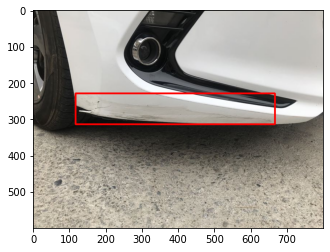

In [31]:
#################################################################################################
#                                                                                               #
# TODO : [ 이미지, ground truth, prediction ] 을 가로로 나란히 subplot 해봅시다.                #
#                                                                                               #
#################################################################################################

target = torchvision.transforms.ToPILImage()(out_target)
#target.save('target.jpg')
#image.save('image.jpg')
images = np.asarray(image)
targets = np.asarray(target)
#print(images.shape)
import cv2
width,height = image.size
#src = cv2.imread('target.jpg',cv2.IMREAD_GRAYSCALE)
src = cv2.resize(targets,(width,height))

_, src_bin = cv2.threshold(src,127, 255, cv2.THRESH_OTSU)

cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(src_bin)


for i in range(1, cnt): 
    (x, y, w, h, area) = stats[i]

    # 노이즈 제거
    if area < 200:
        continue
    cv2.rectangle(images, (x, y, w, h), (255, 0, 0),3)
    

image2 = Image.fromarray(images)
plt.imshow(image2)
plt.show()